In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Add
from keras.callbacks import History
from keras import callbacks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = './reg-fd1/regression_model.h5'
path = './reg-fd1'

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[4, 5, 9, 10, 14, 18, 20, 22, 23, 26, 27]], axis=1, inplace=True)

train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13',
                     's15', 's17', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[4,5,9, 10,14,18,20,22, 23, 26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13',
                     's15', 's17', 's20', 's21']

truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13','s15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

history = History()

input_layer = Input(shape=(sequence_length, nb_features))
x = Conv1D(50, 6, activation = 'relu')(input_layer)
a = Conv1D(50, 6, activation = 'relu')(x)
x = Conv1D(50, 6, activation = 'relu')(x)
b = Add()([a,x]) # SKIP CONNECTION ADDED
x = MaxPooling1D(3)(b)
x = Conv1D(100, 6, activation = 'relu')(x)
x = Conv1D(100, 6, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = LSTM( units=50, input_shape=(1,100), return_sequences=True)(x)
x = LSTM( units=100, return_sequences=True)(x)
c = LSTM( units=100, return_sequences=True)(x)
x = LSTM( units=100, return_sequences=True)(x)
d = Add()([c,x]) # SKIP CONNECTION ADDED
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=nb_out, activation ='linear')(x)
model = Model(input_layer, output_layer)

model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mean_absolute_error','mean_squared_error', keras.metrics.RootMeanSquaredError(), r2_keras])

print(model.summary())

# fit the network
model.fit(seq_array, label_array, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks = [history,
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


   id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s15       s17  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.308965  0.333333   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.213159  0.416667   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.458638  0.416667   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.257022  0.250000   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.300885  0.166667   

        s20       s21  cycle_norm  
0  0.558140  0.661834     0.00000  
1  0.682171  0.68682

2022-02-10 00:13:00.328433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 16)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 45, 50)       4850        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 40, 50)       15050       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 50)       15050       ['conv1d[0][0]']                 
                                                                                              

/Users/shrutirajvanshsingh/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


440/440 [==============================] - 4s 10ms/step - loss: 3927.7949 - mean_absolute_error: 48.2489 - mean_squared_error: 3927.7949 - root_mean_squared_error: 62.6721 - r2_keras: -0.2900 - val_loss: 4914.1416 - val_mean_absolute_error: 54.3356 - val_mean_squared_error: 4914.1416 - val_root_mean_squared_error: 70.1009 - val_r2_keras: -46.4802
Epoch 3/100
440/440 [==============================] - 4s 10ms/step - loss: 3246.6833 - mean_absolute_error: 45.4439 - mean_squared_error: 3246.6833 - root_mean_squared_error: 56.9797 - r2_keras: -0.0680 - val_loss: 4474.7690 - val_mean_absolute_error: 52.9899 - val_mean_squared_error: 4474.7690 - val_root_mean_squared_error: 66.8937 - val_r2_keras: -40.9258
Epoch 4/100
440/440 [==============================] - 4s 10ms/step - loss: 3202.9714 - mean_absolute_error: 45.5853 - mean_squared_error: 3202.9714 - root_mean_squared_error: 56.5948 - r2_keras: -0.0602 - val_loss: 4437.4277 - val_mean_absolute_error: 52.9205 - val_mean_squared_error: 443

Epoch 25/100
440/440 [==============================] - 7s 16ms/step - loss: 301.2136 - mean_absolute_error: 11.7621 - mean_squared_error: 301.2136 - root_mean_squared_error: 17.3555 - r2_keras: 0.8990 - val_loss: 1383.0973 - val_mean_absolute_error: 22.8007 - val_mean_squared_error: 1383.0973 - val_root_mean_squared_error: 37.1900 - val_r2_keras: -13.8598
Epoch 26/100
440/440 [==============================] - 7s 16ms/step - loss: 288.0992 - mean_absolute_error: 11.7114 - mean_squared_error: 288.0992 - root_mean_squared_error: 16.9735 - r2_keras: 0.9036 - val_loss: 1153.1360 - val_mean_absolute_error: 20.8772 - val_mean_squared_error: 1153.1360 - val_root_mean_squared_error: 33.9579 - val_r2_keras: -11.1543
Epoch 27/100
440/440 [==============================] - 7s 16ms/step - loss: 270.0535 - mean_absolute_error: 11.3521 - mean_squared_error: 270.0535 - root_mean_squared_error: 16.4333 - r2_keras: 0.9083 - val_loss: 1260.9390 - val_mean_absolute_error: 21.5968 - val_mean_squared_erro

In [2]:
nb_out

1

In [1]:
model.summary()

NameError: name 'model' is not defined

In [3]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error', 'r2_keras', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_r2_keras'])


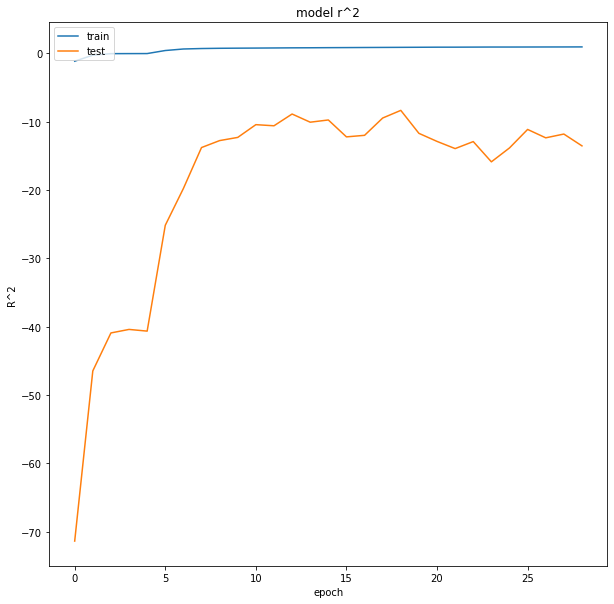

In [4]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"model_r2.png")

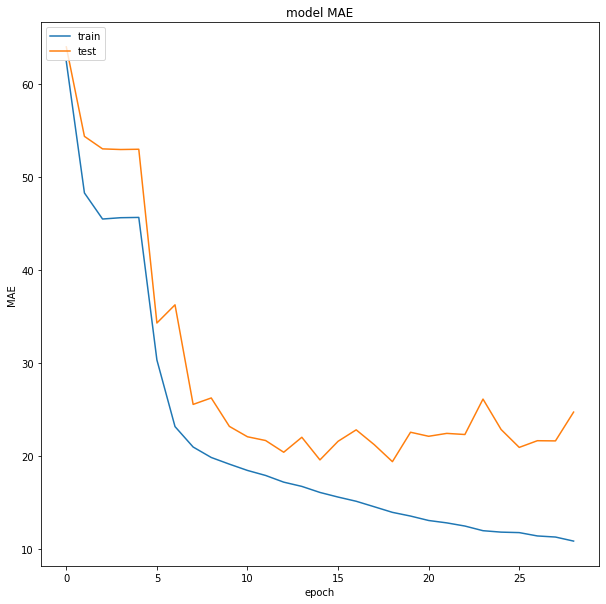

In [5]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_mae.png")

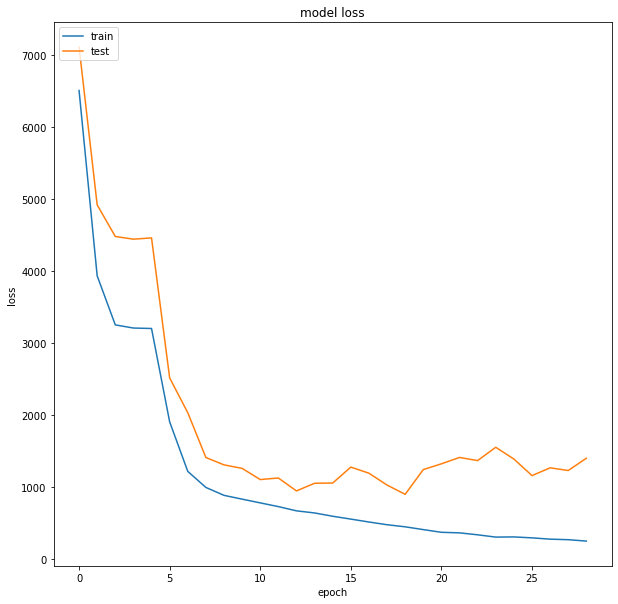

In [6]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_regression_loss.png")

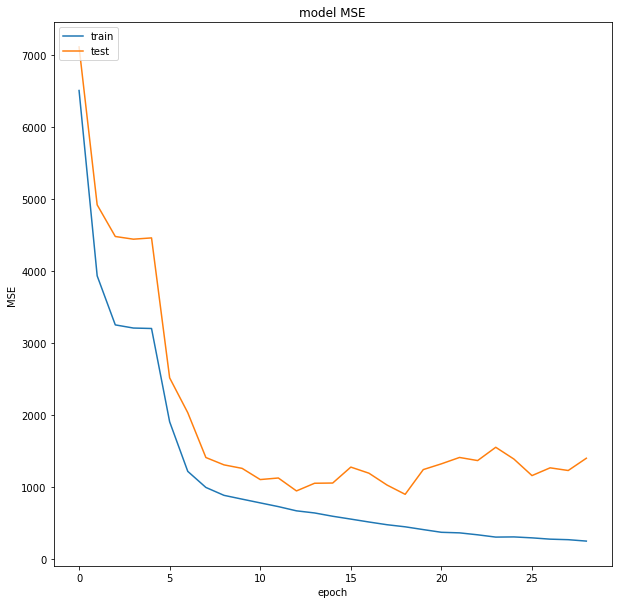

In [7]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_mse.png")

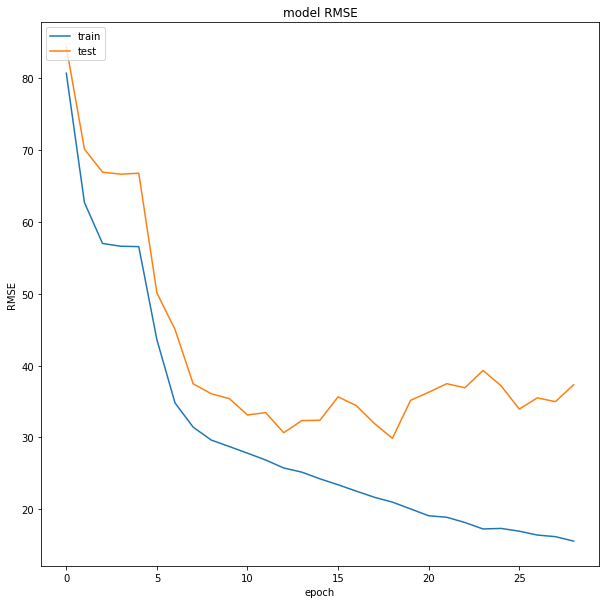

In [8]:
# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_mse.png")

In [9]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nMSE: {}'.format(scores[2]))
print('\nRMSE: {}'.format(scores[3]))
print('\nR^2: {}'.format(scores[4]))
scores

79/79 [==============================] - 1s 13ms/step - loss: 317.0931 - mean_absolute_error: 11.9482 - mean_squared_error: 317.0931 - root_mean_squared_error: 17.8071 - r2_keras: 0.8614

MAE: 11.948169708251953

MSE: 317.0931091308594

RMSE: 17.80710792541504

R^2: 0.8614050149917603


[317.0931091308594,
 11.948169708251953,
 317.0931091308594,
 17.80710792541504,
 0.8614050149917603]

In [10]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

79/79 [==============================] - 3s 11ms/step


3/3 - 2s - loss: 529.4600 - mean_absolute_error: 14.8665 - mean_squared_error: 529.4600 - root_mean_squared_error: 23.0100 - r2_keras: 0.6768 - 2s/epoch - 624ms/step

MAE: 11.948169708251953

MSE: 317.0931091308594

RMSE: 17.80710792541504

R^2: 0.8614050149917603


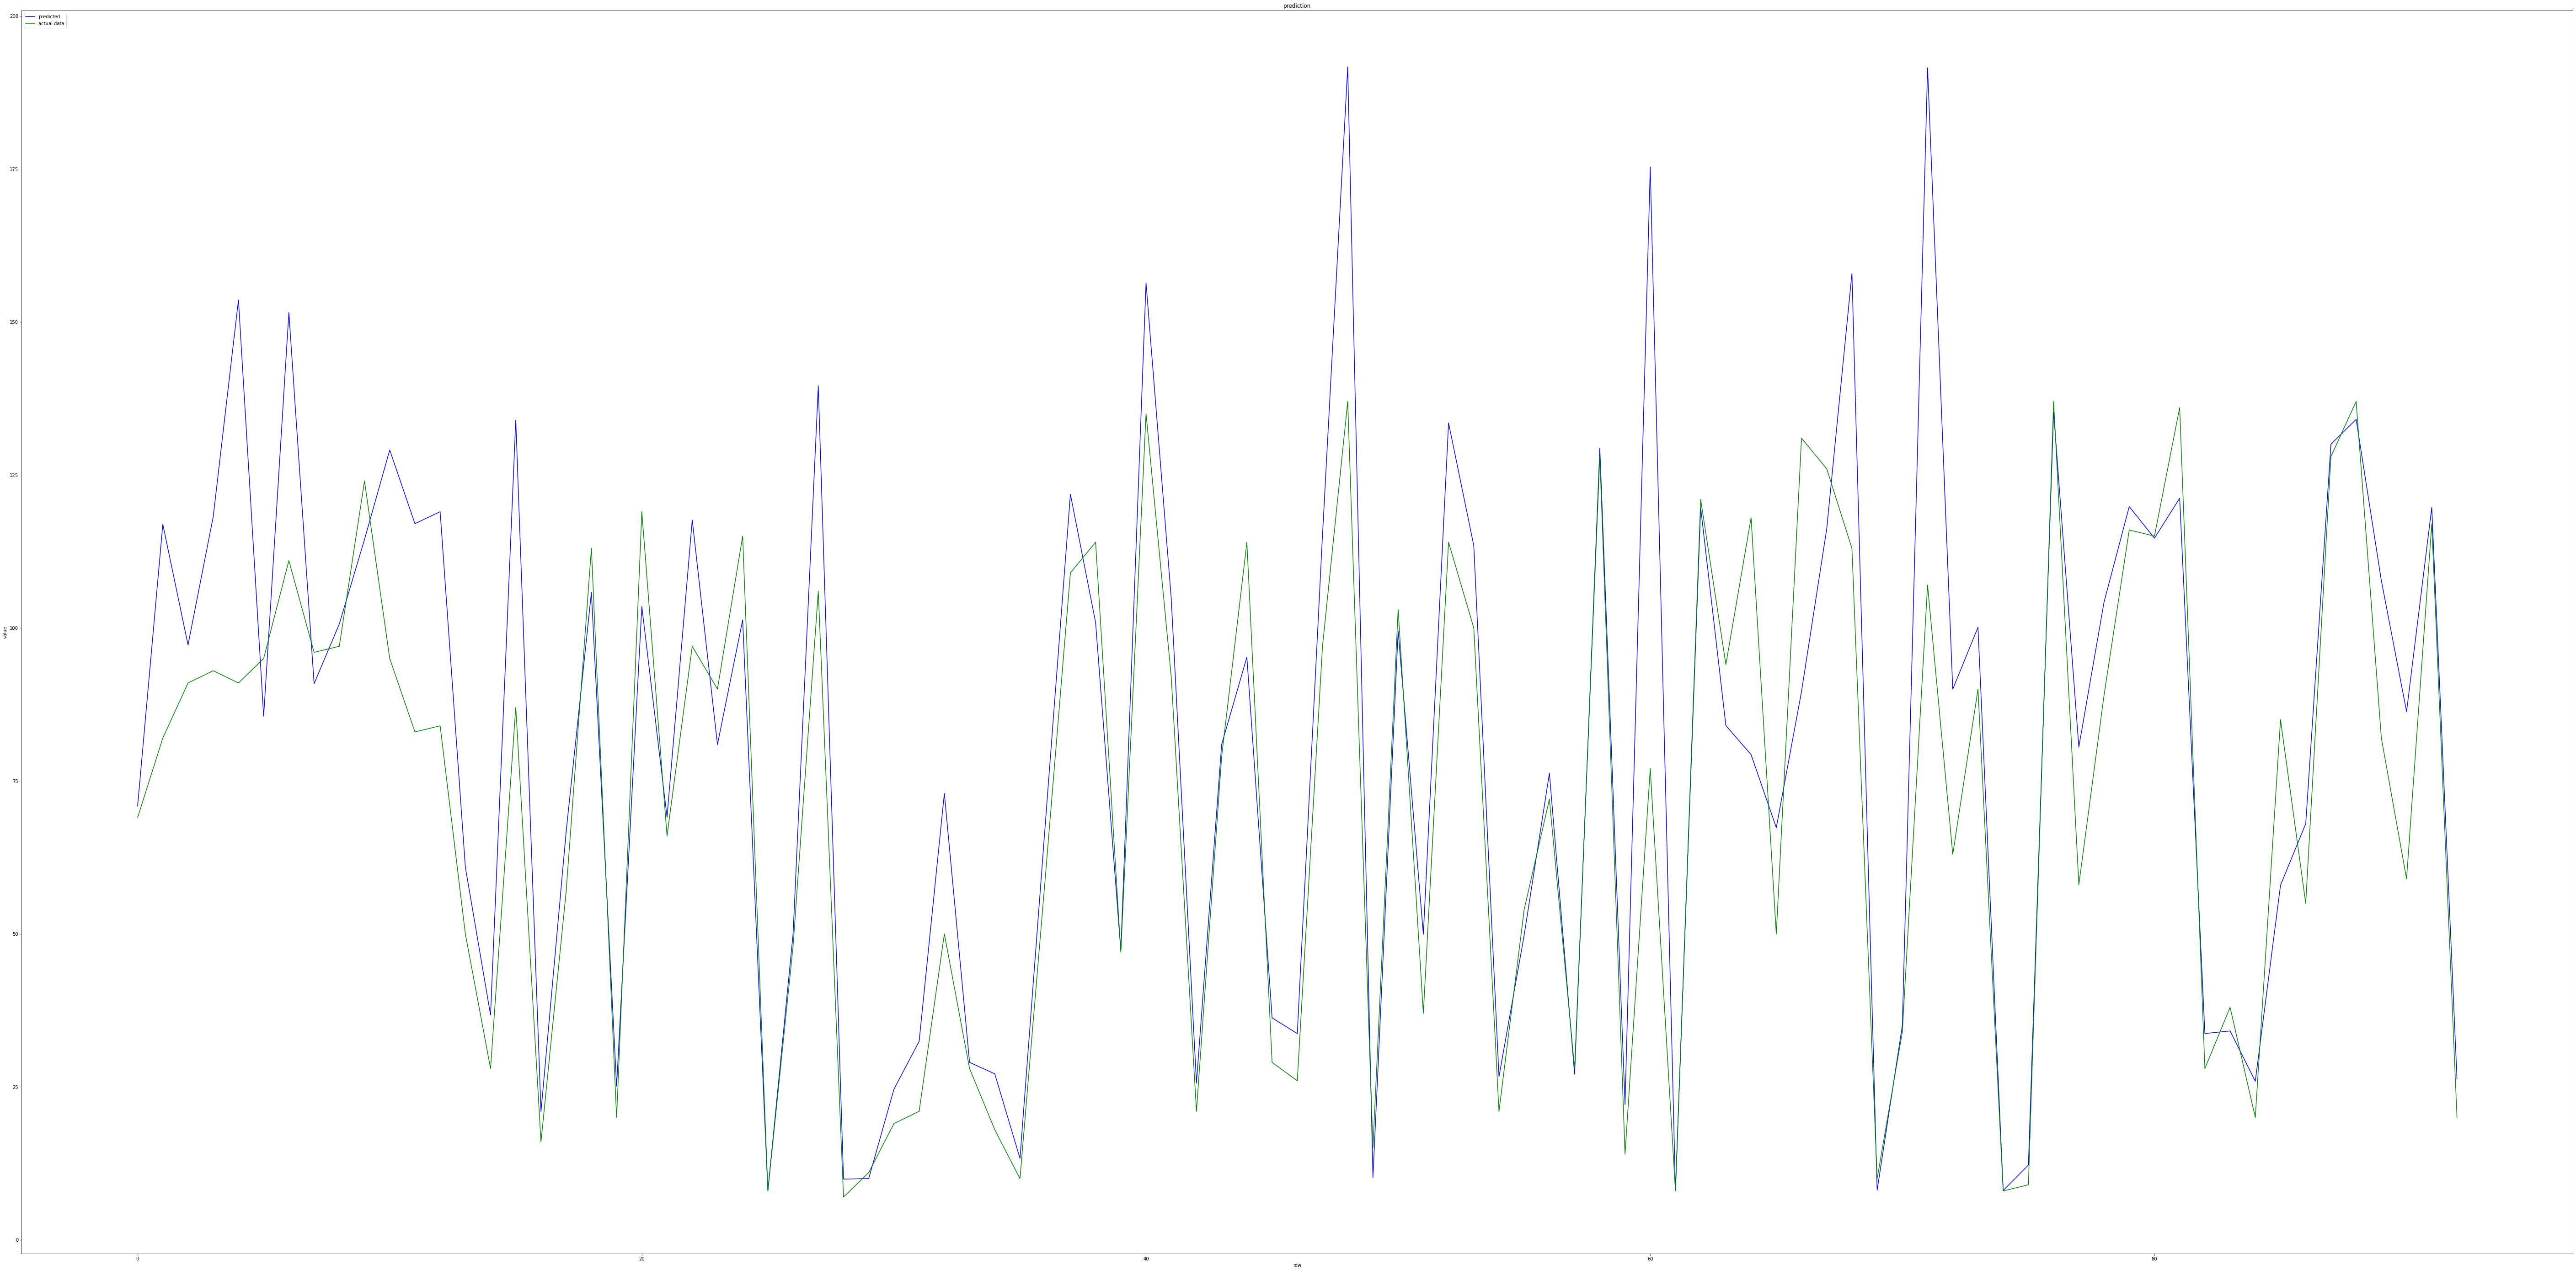

In [11]:

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores[1]))
    print('\nMSE: {}'.format(scores[2]))
    print('\nRMSE: {}'.format(scores[3]))
    print('\nR^2: {}'.format(scores[4]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig(path+"/model_regression_verify.png")